# Basic CLN Construction and Training

In [11]:
import cln

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import trange

No handles with labels found to put in legend.


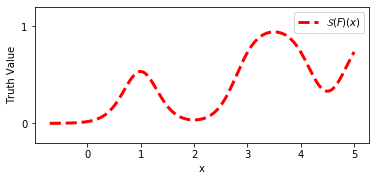

In [7]:
# Can construct CLN using either functional primitives or pytorch modules

# example with basic functions
from cln import prod_tnorm, prod_tconorm, eq, le, ge


B = 5
eps = 0.2

x = torch.tensor(np.linspace(-0.7, 5, 1001))
ycln = prod_tconorm([eq(x - 1.0, B, eps),
                     prod_tnorm([ge(x - 3, B, eps), 
                                 le(x - 4, B, eps)]), 
                    ge(x - 5, B, eps)])


figsize = (6,2.5)
linewidth = 3
plt.figure(figsize=figsize) # SETTING

# plt.plot(x, ydiscrete, 'steelblue', linewidth=2)
plt.plot(x, ycln, 'r--', linewidth=3)
 
plt.legend()
plt.xlabel('x')
plt.ylabel('Truth Value')
plt.ylim([-0.2, 1.2])
plt.yticks([0,1])

plt.legend(['$\mathcal{S}(F)(x)$'])

No handles with labels found to put in legend.


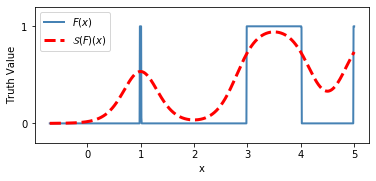

In [10]:
Bdisc = 4000
eps_disc=0.015

ydiscrete = prod_tconorm([eq(x - 1.0, B=Bdisc, eps=eps_disc),
                      prod_tnorm([ge(x - 3, Bdisc, eps_disc), 
                                 le(x - 4, Bdisc, eps_disc)]), 
                         ge(x - 5, Bdisc, eps_disc)])

figsize = (6,2.5)
linewidth = 3
plt.figure(figsize=figsize) # SETTING

plt.plot(x, ydiscrete, 'steelblue', linewidth=2)
plt.plot(x, ycln, 'r--', linewidth=3)
 
plt.legend()
plt.xlabel('x')
plt.ylabel('Truth Value')
plt.ylim([-0.2, 1.2])
plt.yticks([0,1])

plt.legend(['$F(x)$', '$\mathcal{S}(F)(x)$'])

### Solving with Functional API:

100%|██████████| 100/100 [00:00<00:00, 1068.83it/s]

x before tensor(2., requires_grad=True)
x after tensor(3.4892, requires_grad=True)


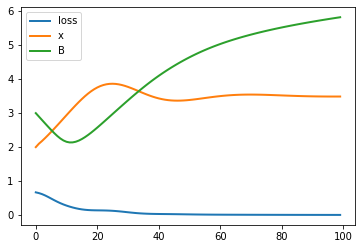

In [34]:
class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = torch.nn.Parameter(torch.tensor(B, requires_grad=True), requires_grad=True)
        self.eps = 0.5
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        ycln = prod_tconorm([eq(x - 1, B, eps),
                     prod_tnorm([ge(x - 3, B, eps), 
                                 le(x - 4, B, eps)]), 
                    ge(x - 5, B, eps)])
        return ycln
        
    
def train(x, model):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.1)
    
    x_trace = []
    loss_trace = []
    B_trace = []
    for i in trange(100):
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())
        x_trace.append(x.item())
        B_trace.append(model.B.item())

        loss.backward()
        opt.step()
        
        model.B.data.clamp_(min=0.5)
        
    return loss_trace, x_trace, B_trace
    
    
x = torch.tensor(2.0, requires_grad=True)

model = CLNModel(B=3.0)

print('x before', x)
lt, xt, bt = train(x, model)
print('x after', x)

def scale(arr, max=1.0):
    arr = np.array(arr)
    return arr * max/arr.max()


plt.plot(lt, linewidth=2)
plt.plot(xt, linewidth=2)
plt.plot(bt, linewidth=2)
plt.legend(['loss', 'x', 'B'])